In [1]:
import os.path as osp
import numpy as np
import pandas as pd
import pathlib, sys, os, random, time
import numba, cv2, gc
from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from tqdm.notebook import tqdm

import albumentations as A

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as D
torch.backends.cudnn.enabled = True

import torchvision
from torchvision import transforms as T

In [3]:
EPOCHES = 20
BATCH_SIZE = 8
IMAGE_SIZE = 256
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu' 

trfm = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(),
])


In [4]:
class TianChiDataset(D.Dataset):
    def __init__(self, paths, transform, test_mode=False):
        self.paths = paths
        self.transform = transform
        self.test_mode = test_mode
        
        self.len = len(paths)
        self.as_tensor = T.Compose([
            T.ToPILImage(),
            T.Resize(IMAGE_SIZE),
            T.ToTensor(),
            T.Normalize([0.625, 0.448, 0.688],
                        [0.131, 0.177, 0.101]),
        ])
        
    # get data operation
    def __getitem__(self, index):
        img = cv2.imread(self.paths[index])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if not self.test_mode:
            mask = cv2.imread(self.paths[index].replace('.tif', '.png')) - 1
            mask = cv2.resize(mask, (IMAGE_SIZE, IMAGE_SIZE))
            augments = self.transform(image=img, mask=mask)
            return self.as_tensor(augments['image']), augments['mask'][:, :, 0].astype(np.int64)
        else:
            return self.as_tensor(img), ''        
    
    def __len__(self):
        """
        Total number of samples in the dataset
        """
        return self.len

In [5]:
import glob
dataset_path = '/media/alex/80CA308ECA308288/alex_dataset/ecological-assets'


dataset = TianChiDataset(
    glob.glob(osp.join(dataset_path, 'suichang_round1_train_210120', '*.tif')),
    trfm, False
)

TypeError: Invalid shape (3, 256, 256) for image data

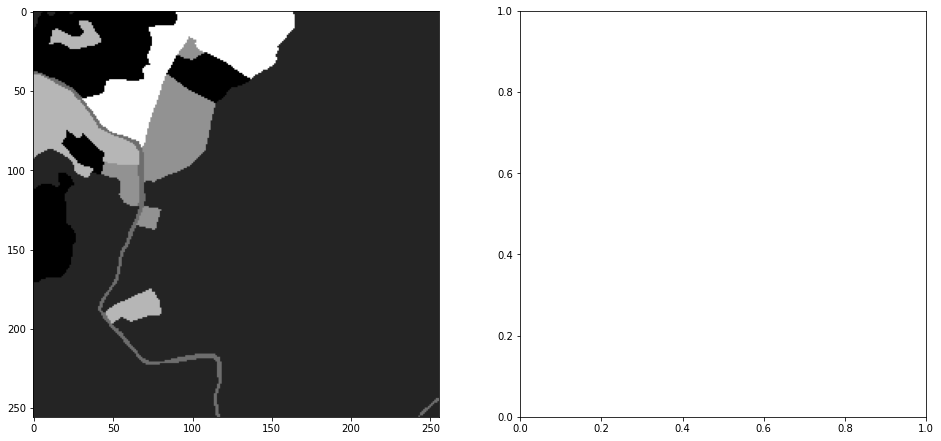

In [6]:
image, mask = dataset[150]
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(mask, cmap='gray')
plt.subplot(122)
plt.imshow(image)

## deine model

In [7]:
def get_model():
    model = torchvision.models.segmentation.fcn_resnet50(True)
    
    model.classifier[4] = nn.Conv2d(512, 10, kernel_size=(1, 1), stride=(1, 1))
    return model

### validataion 

In [8]:
def validation(model, loader, loss_fn):
    val_iou = []
    model.eval()
    with torch.no_grad():
        for image, target in loader:
            image, target = image.to(DEVICE), target.to(DEVICE)
            output = model(image)
            output = output.argmax(1)
            iou = get_iou(output, target)
            val_iou.append(iou)

        return val_iou


def get_iou(pred, mask, c=10):
    iou_result = []
    for idx in range(c):
        p = (mask == idx).int().reshape(-1)
        t = (pred == idx).int().reshape(-1)

        uion = p.sum() + t.sum()
        overlap = (p*t).sum()
        
        # print(idx, uion, overlap)
        
        iou = 2*overlap/(p.sum() + t.sum() +0.001)
        iou_result.append(iou.abs().data.cpu().numpy())
    return np.stack(iou_result)

## train

In [9]:
header = r'''
        Train | Valid
Epoch |  Loss |  Loss | Time, m
'''
#          Epoch         metrics            time
raw_line = '{:6d}' + '\u2502{:7.3f}'*2 + '\u2502{:6.2f}'
print(header)
class_name = ['farm','land','forest','grass','road','urban_area',
                 'countryside','industrial_land','construction',
                 'water', 'bareland']
print('  '.join(class_name))

val_idx, train_idx = [], []


### 5 flod validataion
for fold_idx in range(0, 5):
    for i in range(len(dataset)):
        if i % 5 == fold_idx:
            val_idx.append(i)
        else:
    #     elif i % 7 == 1:
            train_idx.append(i)

    train_ds = D.Subset(dataset, train_idx)
    valid_ds = D.Subset(dataset, val_idx)

    # define training and validation data loaders
    loader = D.DataLoader(
        train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

    vloader = D.DataLoader(
        valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

    import segmentation_models_pytorch as smp
    model = smp.Unet(
            encoder_name="resnet50",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
            encoder_weights="imagenet",     # use `imagenet` pretreined weights for encoder initialization
            in_channels=3,                  # model input channels (1 for grayscale images, 3 for RGB, etc.)
            classes=10,                      # model output channels (number of classes in your dataset)
    )
    model.to(DEVICE);
    optimizer = torch.optim.AdamW(model.parameters(),
                      lr=1e-4, weight_decay=1e-3)
    loss_fn = nn.CrossEntropyLoss().to(DEVICE);
    
    best_iou = 0
    for epoch in range(1, EPOCHES+1):
        losses = []
        start_time = time.time()
        model.train()
        model.to(DEVICE);
        for image, target in tqdm_notebook(loader):

            image, target = image.to(DEVICE), target.to(DEVICE)
            optimizer.zero_grad()
            output = model(image)

            # break
            loss = loss_fn(output, target)
            loss.backward()

            optimizer.step()
            losses.append(loss.item())

        viou = validation(model, vloader, loss_fn)
        print('\t'.join(np.stack(viou).mean(0).round(3).astype(str)))

        print(raw_line.format(epoch, np.array(losses).mean(), np.mean(viou),
                                  (time.time()-start_time)/60**1))    
        if best_iou < np.stack(viou).mean(0).mean():
            best_iou = np.stack(viou).mean(0).mean()
            torch.save(model.state_dict(), 'model_{0}.pth'.format(fold_idx))
            
    break


        Train | Valid
Epoch |  Loss |  Loss | Time, m

farm  land  forest  grass  road  urban_area  countryside  industrial_land  construction  water  bareland



0.615	0.92	0.0	0.0	0.0	0.459	0.0	0.0	0.511	0.0
     1│  0.658│  0.251│  4.73



0.7	0.931	0.0	0.112	0.046	0.546	0.001	0.0	0.596	0.0
     2│  0.432│  0.293│  4.76



0.666	0.927	0.0	0.148	0.042	0.469	0.0	0.0	0.541	0.0
     3│  0.400│  0.279│  4.76



0.689	0.933	0.0	0.173	0.066	0.526	0.007	0.0	0.611	0.0
     4│  0.382│  0.300│  4.78



0.71	0.935	0.0	0.182	0.051	0.562	0.058	0.0	0.628	0.0
     5│  0.370│  0.313│  4.84



0.721	0.936	0.0	0.204	0.031	0.571	0.095	0.0	0.636	0.0
     6│  0.357│  0.320│  4.89



0.697	0.935	0.0	0.217	0.056	0.587	0.088	0.0	0.64	0.0
     7│  0.348│  0.322│  4.84



0.72	0.937	0.0	0.241	0.034	0.597	0.067	0.003	0.655	0.0
     8│  0.341│  0.326│  4.81



0.721	0.937	0.0	0.207	0.071	0.594	0.093	0.005	0.658	0.0
     9│  0.334│  0.329│  4.93



0.736	0.94	0.0	0.172	0.051	0.596	0.096	0.022	0.645	0.0
    10│  0.327│  0.326│  4.85



0.714	0.937	0.0	0.202	0.074	0.578	0.081	0.022	0.64	0.0
    11│  0.321│  0.325│  4.84



0.731	0.94	0.0	0.225	0.068	0.607	0.095	0.046	0.663	0.0
    12│  0.317│  0.338│  4.81



0.732	0.94	0.001	0.21	0.073	0.561	0.095	0.073	0.665	0.0
    13│  0.309│  0.335│  4.82



0.737	0.939	0.025	0.224	0.027	0.589	0.07	0.065	0.658	0.0
    14│  0.303│  0.333│  4.79



0.741	0.941	0.048	0.212	0.069	0.617	0.115	0.062	0.659	0.0
    15│  0.299│  0.346│  4.78



0.755	0.944	0.037	0.235	0.072	0.62	0.098	0.079	0.682	0.0
    16│  0.293│  0.352│  4.90



0.697	0.92	0.047	0.186	0.052	0.574	0.111	0.068	0.639	0.0
    17│  0.290│  0.330│  4.86



0.721	0.938	0.083	0.224	0.073	0.589	0.121	0.076	0.655	0.001
    18│  0.286│  0.348│  4.87



0.721	0.934	0.072	0.231	0.083	0.602	0.11	0.07	0.673	0.001
    19│  0.280│  0.350│  4.95



0.726	0.934	0.043	0.186	0.09	0.596	0.124	0.073	0.638	0.002
    20│  0.278│  0.341│  4.94


## inference

In [ ]:
trfm = T.Compose([
    T.ToPILImage(),
    T.Resize(IMAGE_SIZE),
    T.ToTensor(),
    T.Normalize([0.625, 0.448, 0.688],
                [0.131, 0.177, 0.101]),
])

import segmentation_models_pytorch as smp
model = smp.Unet(
            encoder_name="resnet50",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
            encoder_weights="imagenet",     # use `imagenet` pretreined weights for encoder initialization
            in_channels=3,                  # model input channels (1 for grayscale images, 3 for RGB, etc.)
            classes=10,                      # model output channels (number of classes in your dataset)
    )
model.to(DEVICE);

model.load_state_dict(torch.load("./model_0.pth"))
model.eval()


for idx, name in enumerate(tqdm_notebook(glob.glob('./suichang_round1_test_partA_210120/*.tif')[:])):
    image = cv2.imread(name)
    image = trfm(image)
    with torch.no_grad():
        image = image.to(DEVICE)[None]
        score1 = model(image).cpu().numpy()
        
        score2 = model(torch.flip(image, [0, 3]))
#         score2 = score2.cpu().numpy()
        score2 = torch.flip(score2, [3, 0]).cpu().numpy()

        score3 = model(torch.flip(image, [0, 2]))
#         score3 = score3.cpu().numpy()
        score3 = torch.flip(score3, [2, 0]).cpu().numpy()
        
        score = (score1 + score2 + score3) / 3.0
        
        score_sigmoid = score[0].argmax(0) + 1
#         score_sigmoid = (score_sigmoid > 0.5).astype(np.uint8)
        
#         plt.figure(figsize=(16,8))
#         plt.subplot(151)
#         plt.imshow((score1[0].argmax(0) + 1)*30, cmap='gray')
#         plt.subplot(152)
#         plt.imshow((score2[0].argmax(0) + 1)*30, cmap='gray')
#         plt.subplot(153)
#         plt.imshow((score3[0].argmax(0) + 1)*30, cmap='gray')
#         plt.subplot(154)
#         plt.imshow((score[0].argmax(0) + 1)*30, cmap='gray')
#         plt.subplot(155)
#         image = cv2.imread(name)
#         plt.imshow(image);

        # break
        print(score_sigmoid.min(), score_sigmoid.max())
        cv2.imwrite('results/' + name.split('/')[-1].replace('.tif', '.png'), score_sigmoid)
    # break

In [ ]:
!zip -r results.zip results